In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import yfinance as yf
import pandas as pd
import numpy as np
from src.gpu.simulation_based_tree import SimulationBasedModel
from src.simulations import PathSimulator
import torch
from datetime import datetime
from tqdm import tqdm
from IPython.display import clear_output
import seaborn as sns

## Calibration of models


In [3]:


def fetch_options(ticker : str):
    # Initialize the AAPL stock object
    aapl = yf.Ticker(ticker)
    
    # Fetch available option expiration dates
    expiration_dates = aapl.options

    # Initialize a DataFrame to store all options data
    all_options = pd.DataFrame()

    # Loop over each expiration date and fetch the option chain
    for date in expiration_dates:
        # Fetch options for this expiration date
        options_chain = aapl.option_chain(date)
        
        # Combine calls and puts into one DataFrame with an expiration date column
        calls = options_chain.calls
        calls['type'] = 'call'
        calls['expirationDate'] = pd.to_datetime(date)

        puts = options_chain.puts
        puts['type'] = 'put'
        puts['expirationDate'] = pd.to_datetime(date)

        # Concatenate calls and puts
        all_options = pd.concat([all_options, calls, puts])

    return all_options.reset_index(drop=True)


In [4]:
aapl_options = fetch_options('AAPL')
aapl_options['lastTradeDay'] = pd.to_datetime(aapl_options.lastTradeDate.dt.date)
aapl_options = aapl_options[~aapl_options.volume.isna()]
aapl_options['option_price'] = (aapl_options['bid']+aapl_options['ask'])/2
aapl_options['T'] = aapl_options.apply(lambda x: (len(pd.bdate_range(datetime.today().date(), x['expirationDate'])) - 1)/252, axis = 1)
aapl_options.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,type,expirationDate,lastTradeDay,option_price,T
0,AAPL241115C00005000,2024-11-11 14:52:20+00:00,5.0,218.34,219.45,220.05,0.0,0.0,1.0,1,19.234379,True,REGULAR,USD,call,2024-11-15,2024-11-11,219.750,0.011905
1,AAPL241115C00010000,2024-11-07 20:50:00+00:00,10.0,217.50,213.70,214.35,0.0,0.0,1.0,0,12.140627,True,REGULAR,USD,call,2024-11-15,2024-11-07,214.025,0.011905
4,AAPL241115C00025000,2024-11-07 20:55:00+00:00,25.0,202.10,199.35,199.95,0.0,0.0,2.0,0,9.863285,True,REGULAR,USD,call,2024-11-15,2024-11-07,199.650,0.011905
7,AAPL241115C00050000,2024-11-07 20:06:51+00:00,50.0,177.63,174.40,174.35,0.0,0.0,1.0,0,5.843753,True,REGULAR,USD,call,2024-11-15,2024-11-07,174.375,0.011905
8,AAPL241115C00055000,2024-03-08 14:30:05+00:00,55.0,115.75,114.90,117.45,0.0,0.0,2.0,2,0.000010,True,REGULAR,USD,call,2024-11-15,2024-03-08,116.175,0.011905


In [5]:
start_date = aapl_options['lastTradeDay'].min()
end_date = aapl_options['lastTradeDay'].max()

In [6]:
str(start_date.date())

'2024-03-08'

In [7]:
aapl_prices = yf.download("AAPL", start = str(start_date.date()), end = str(end_date.date()))[['Close']].droplevel(level = 0, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [8]:
aapl_prices.iloc[-1]

Ticker
AAPL    224.229996
Name: 2024-11-11 00:00:00+00:00, dtype: float64

In [9]:
aapl_prices.index = aapl_prices.index.tz_localize(None)

In [10]:
aapl_options = aapl_options.sort_values("lastTradeDate")

In [11]:
aapl_options['underlying_price'] = aapl_prices.iloc[-1].item()

In [12]:
aapl_options[['underlying_price']]

,underlying_price
8,224.229996
1115,224.229996
649,224.229996
436,224.229996
1428,224.229996
...,...
183,224.229996
298,224.229996
615,224.229996
180,224.229996


## Train-test split

In [45]:
L = len(aapl_options)
train_df = aapl_options
test_df = aapl_options.iloc[(L*7)//10:]

In [46]:
t = train_df['T'].unique()[0]

In [47]:
Ks = train_df.query(f"T == {t} & type == 'call'").strike
px = train_df.query(f"T == {t} & type == 'call'").option_price


In [48]:
df = pd.concat([Ks, px], axis = 1).sort_values("strike")
Ks, px = df['strike'], df['option_price']

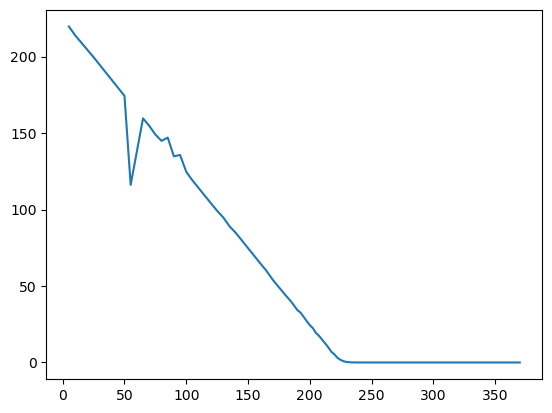

In [49]:
import matplotlib.pyplot as plt

plt.plot(Ks, px)

## Calibrating

In [50]:
simulator = PathSimulator()


In [51]:
# kappa = 5.0
# K = 10
# r = 0.0
# eta = 0.9
# theta = 0.04
# rho = 0.1
# T = 0.25
# v0 = theta
# S0 = 10
# N = 200
# M = 10_000
# dt = T/N

In [ ]:
# initial_params = torch.Tensor([0.1,0.1, 0.01, 0.1, 0.1, 0.1],).to('cuda') #rho, kappa, theta, v0, s0, eta, r
# initial_params.requires_grad = True
# optimizer = torch.optim.Adam([initial_params], lr=0.01)
device = 'cuda'
import gc

import torch.nn.functional as F

rho = torch.nn.Parameter(torch.atanh(torch.tensor(-0.5)))    # Correlation rho in [-1, 1]
kappa = torch.nn.Parameter(torch.tensor(5.0))    # Mean reversion rate, ensure positivity
theta = torch.nn.Parameter(torch.tensor(0.16))              # Long-run variance, positive
v0 = torch.nn.Parameter(torch.tensor(0.25**2))                 # Initial variance, set equal to theta
eta = torch.nn.Parameter(torch.tensor(0.9))                 # Volatility of volatility, positive
r = torch.nn.Parameter(torch.tensor(0.1))      

params = [rho, kappa, theta, v0, eta, r]
optimizer = torch.optim.Adam(params, lr=1e-2)

def transformed_params(rho, kappa, theta, v0, eta, r):
    # [-1, 1] range: scaled tanh (less extreme than directly using torch.tanh)
    rho_ = torch.tanh(rho)   # Slightly scaled to avoid extremes

    # [0, 1] range: sigmoid with slight scaling
    kappa_ = F.softplus(kappa)  # Ensures values are in (0.01, 0.99)
    r_ = F.softplus(r)         # Same for r to avoid edges
    
    # Positive range: softplus (less extreme than exp)
    theta_ = F.softplus(theta) + 1e-6            # Ensures positive values, avoids zero
    v0_ = F.softplus(v0) + 1e-6                  # Ensures positive values, avoids zero
    eta_ = F.softplus(eta) + 1e-6                # Ensures positive values, avoids zero

    # Feller condition for eta: eta <= sqrt(2 * kappa * theta)
    eta_ = torch.min(eta_, torch.sqrt(2 * kappa_ * theta_))

    return rho_, kappa_, theta_, v0_, eta_, r_

# Apply transformations in the forward pass

n = 50
m = 500*n

losses = []

# Optimization loop
num_iterations = 100
batch_size = 64
memo = {}

best_params = None
best_loss = float('inf')

# with torch.autograd.set_detect_anomaly(True):
for iteration in range(num_iterations):

    optimizer.zero_grad()

    rho_, kappa_, theta_, v0_, eta_, r_ = transformed_params(rho, kappa, theta, v0, eta, r)
    print([rho_, kappa_, theta_, v0_, eta_, r_])


    stochastic_df = train_df.query("type == 'put'").sample(batch_size, replace=False)
    model_prices = torch.zeros(len(stochastic_df), device=device)
    market_prices = torch.zeros(len(stochastic_df), device=device)
    Ks = torch.zeros(len(stochastic_df), device=device)
    # rho, kappa, theta, v0, eta, r = initial_params
    # batch_loss = (rho**2 + kappa**2 + theta**2 + v0**2 + eta**2 + r**2) 


    for i, (idx, row) in tqdm(enumerate(stochastic_df.iterrows()), total = len(stochastic_df)):
        T = row['T']
        option_type = row['type']
        market_price = row['option_price']
        S0 = row['underlying_price']
        K = row['strike']


        if option_type == 'call':
            g= lambda x, k: torch.maximum(x-k, torch.tensor(0))

        elif option_type == 'put':
        
            g= lambda x, k: torch.maximum(k-x, torch.tensor(0))

        pricer = SimulationBasedModel(n,row['strike'], r_, T/n, option_type='american', model = 'heston', device=device)
        St, _ = simulator.heston_gpu(T,m,n,rho_, kappa_, theta_, v0_, S0,eta_, r_, device = device)

        
        # option_price = pricer.compute_option_prices_counting(St, g)


        M, n = St.shape
        dt = T/n
        memo = {}


        for t in range(n - 1, -1, -1):

            # Compute quantile bins for current and next time steps
            bins_current, prices_t = pricer.compute_quantiles(St[:, t], t+3)

            if t == n-1:
                memo[t] = (g(prices_t[1:-1], K))
                continue

            bins_next, prices_t_next = pricer.compute_quantiles(St[:, t + 1], t+4)
            
            probabilities = pricer.compute_transition_matrix(
                bins_current, 
                bins_next,
            )


            continuation_values = probabilities @ (memo[t+1] * torch.exp(-r_* dt))

            stopping_values_all = g(prices_t[1:-1], K)
            
            # del bins_current
            # del prices_t
            # del bins_next
            # torch.cuda.empty_cache()
            # gc.collect()

            memo[t] = torch.maximum(continuation_values, stopping_values_all)

            if memo[t].isnan().any():
                break


        # Option price at time 0
        option_price = memo[0][0]

        if option_price.isnan():
            break

        model_prices[i] = option_price
        market_prices[i] = torch.tensor(market_price, device= device)
        Ks[i] = K

    


    batch_loss = (abs(model_prices  - market_prices)**2).sum()
    # batch_loss.requires_grad =True
    batch_loss = batch_loss / batch_size

    if batch_loss < best_loss:
        best_loss = batch_loss
        best_parameters = params

    losses.append(batch_loss.item())
    # break
    batch_loss.backward()
    optimizer.step()



    clear_output()
    print(f"Iteration {iteration + 1}/{num_iterations}, Loss: {batch_loss.item():.6f}")
    print([rho_, kappa_, theta_, v0_, eta_, r_])
    # print(rho.grad)

[tensor(-0.5000, grad_fn=<TanhBackward0>), tensor(5.0067, grad_fn=<SoftplusBackward0>), tensor(0.7763, grad_fn=<AddBackward0>), tensor(0.7249, grad_fn=<AddBackward0>), tensor(1.2412, grad_fn=<MinimumBackward0>), tensor(0.7444, grad_fn=<SoftplusBackward0>)]


 88%|████████▊ | 56/64 [00:04<00:00, 13.77it/s]

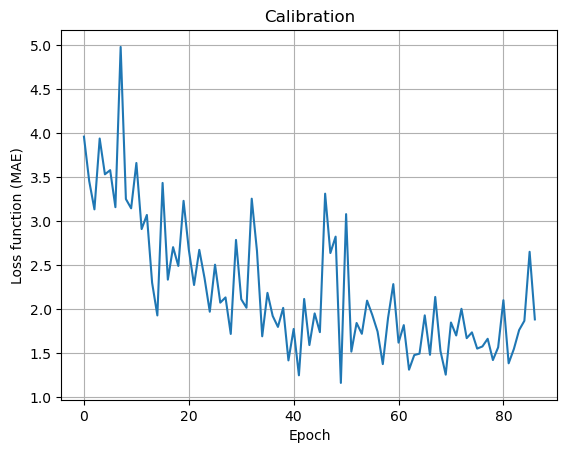

In [ ]:
plt.plot(losses)
plt.title("Calibration")
plt.ylabel("Loss function (MSE)")
plt.xlabel("Epoch")
plt.grid()

In [75]:
best_parameters

[Parameter containing:
 tensor(nan, requires_grad=True),
 Parameter containing:
 tensor(nan, requires_grad=True),
 Parameter containing:
 tensor(nan, requires_grad=True),
 Parameter containing:
 tensor(nan, requires_grad=True),
 Parameter containing:
 tensor(nan, requires_grad=True),
 Parameter containing:
 tensor(0.4785, requires_grad=True)]

In [76]:
rho, kappa, theta, v0, eta, r = best_parameters
rho_, kappa_, theta_, v0_, eta_, r_ = transformed_params(rho, kappa, theta, v0, eta, r)

n = 200
m = 500*n

df = train_df.query("type == 'put'")

model_prices = torch.zeros(len(df), device=device)
market_prices = torch.zeros(len(df), device=device)
Ks = torch.zeros(len(df), device=device)

with torch.no_grad():
    for i, (idx, row) in tqdm(enumerate(df.iterrows()), total = len(df)):
        T = row['T']
        option_type = row['type']
        market_price = row['option_price']
        S0 = row['underlying_price']
        K = row['strike']


        if option_type == 'call':
            g= lambda x, k: torch.maximum(x-k, torch.tensor(0))

        elif option_type == 'put':
        
            g= lambda x, k: torch.maximum(k-x, torch.tensor(0))

        pricer = SimulationBasedModel(n,row['strike'], r_, T/n, option_type='american', model = 'heston', device=device)
        St, _ = simulator.heston_gpu(T,m,n,rho_, kappa_, theta_, v0_, S0,eta_, r_, device = device)

        
        # option_price = pricer.compute_option_prices_counting(St, g)


        M, n = St.shape
        dt = T/n
        memo = {}


        for t in range(n - 1, -1, -1):

            # Compute quantile bins for current and next time steps
            bins_current, prices_t = pricer.compute_quantiles(St[:, t], t+3)

            if t == n-1:
                memo[t] = (g(prices_t[1:-1], K))
                continue

            bins_next, prices_t_next = pricer.compute_quantiles(St[:, t + 1], t+4)
            
            probabilities = pricer.compute_transition_matrix(
                bins_current, 
                bins_next,
            )


            continuation_values = probabilities @ (memo[t+1] * torch.exp(-r_* dt))

            stopping_values_all = g(prices_t[1:-1], K)
            
            # del bins_current
            # del prices_t
            # del bins_next
            # torch.cuda.empty_cache()
            # gc.collect()

            memo[t] = torch.maximum(continuation_values, stopping_values_all)

            if memo[t].isnan().any():
                break


        # Option price at time 0
        option_price = memo[0][0]

        if option_price.isnan():
            break

        model_prices[i] = option_price
        market_prices[i] = torch.tensor(market_price, device= device)
        Ks[i] = K

  0%|          | 0/845 [00:00<?, ?it/s]

  0%|          | 0/845 [00:00<?, ?it/s]


ValueError: NaN detected at timestep 199 in St or vt

In [63]:
market_prices = market_prices.detach().cpu().numpy()
model_prices = model_prices.detach().cpu().numpy()

<Axes: ylabel='Density'>

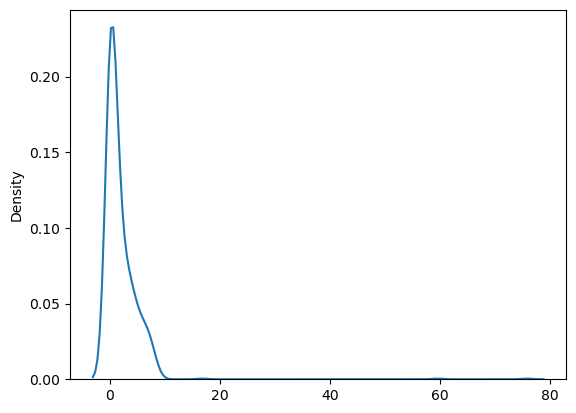

In [70]:
sns.kdeplot(abs(market_prices - model_prices))

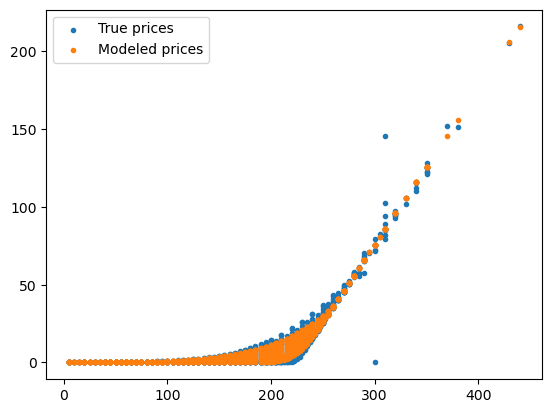

In [72]:

plt.scatter(Ks.cpu(), market_prices, marker='.', label = 'True prices')
plt.scatter(Ks.cpu(), model_prices, marker='.', label = "Modeled prices")

plt.legend()

In [ ]:
(market_prices - model_prices)**2

array([ 5.95299988e+01,  4.99999989e-03,  1.67799988e+01, -3.59500122e+00,
        6.12998962e+00,  8.20499420e+00, -2.70004272e-01, -1.82000732e+00,
       -2.64500427e+00, -4.77000427e+00,  4.99999989e-03, -4.39500427e+00,
        3.50499725e+00,  4.99999989e-03,  4.99999989e-03,  3.82999420e+00,
        4.99999989e-03,  4.99999989e-03,  1.67999268e+00,  1.55499268e+00,
        1.80499268e+00,  1.25000000e-01,  2.67999649e+00,  4.30499268e+00,
       -4.19500732e+00, -4.09500122e+00,  4.99999989e-03, -3.64500427e+00,
       -3.54500580e+00,  9.99999978e-03,  1.49999997e-02, -5.42000580e+00,
       -3.39500427e+00, -3.42000580e+00,  1.99999996e-02,  1.99999996e-02,
       -5.09500504e+00, -7.99500275e+00,  5.49999997e-02,  4.99999989e-03,
        1.09999999e-01,  9.99999978e-03, -6.32000732e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -7.57700043e+01,  0.00000000e+00,
        9.99999978e-03,  1.49999997e-02,  3.41688693e-02,  1.80499649e+00,
        7.50000030e-02,  